# Phase 2: Dynamic Topic Modeling (BERTopic)
**Goal:** Uncover latent economic themes and track their evolution over time.

## Methodology
1.  **Embeddings:** `all-MiniLM-L6-v2` (Sentence Transformers).
2.  **Dimensionality Reduction:** `UMAP`.
3.  **Clustering:** `HDBSCAN`.
4.  **Topic Modeling:** `c-TF-IDF`.
5.  **Dynamic Analyis:** Tracking topics by Date.

## Setup

In [2]:
# !pip install bertopic sentence-transformers umap-learn hdbscan
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import os

# Load Data
DATA_PATH = '../data/master/fed_master_corpus.csv'
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
timestamps = df.date.to_list()
docs = df.text.to_list()

print(f"Loaded {len(docs)} documents.")

Loaded 7442 documents.


## 1. Configure Pipeline
We use a custom configuration to ensure stable results.

In [3]:
# 1. Embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Dimensionality Reduction
# metric='cosine' is standard for embeddings
umap_search = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# 3. Clustering
# min_cluster_size=15 ensures we don't get tiny, noisy topics
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 4. Main Model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_search,
    hdbscan_model=hdbscan_model,
    verbose=True
)

## 2. Fit and Transform (Training)
This may take a few minutes.

In [4]:
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

2025-12-24 16:06:28,781 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/233 [00:00<?, ?it/s]

2025-12-24 16:07:03,995 - BERTopic - Embedding - Completed ✓
2025-12-24 16:07:03,996 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-24 16:07:41,567 - BERTopic - Dimensionality - Completed ✓
2025-12-24 16:07:41,568 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-24 16:07:41,796 - BERTopic - Cluster - Completed ✓
2025-12-24 16:07:41,800 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-24 16:07:42,086 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2558,-1_we_that_you_and,"[we, that, you, and, the, to, of, it, know, so]","[So a couple of things. First, on the forecast..."
1,0,240,0_fomc_funds_federal_rate,"[fomc, funds, federal, rate, participants, tar...","[In conjunction with this FOMC meeting, partic..."
2,1,149,1_trade_global_outlook_sentiment,"[trade, global, outlook, sentiment, risks, chi...",[Investors pointed to a number of uncertaintie...
3,2,137,2_outlook_policy_risks_data,"[outlook, policy, risks, data, incoming, commi...",[We will make decisions about the extent of ad...
4,3,134,3_yields_treasury_nominal_implied,"[yields, treasury, nominal, implied, path, per...","[Over the intermeeting period, U.S. Treasury y..."
...,...,...,...,...,...
99,98,17,98_emes_capital_flows_economies,"[emes, capital, flows, economies, advanced, cr...","[And, more recently, capital flows to EMEs hav..."
100,99,16,99_items_energy_food_12,"[items, energy, food, 12, overall, basis, mont...","[On a 12-month basis, overall inflation and in..."
101,100,16,100_transitory_inflation_largely_factors,"[transitory, inflation, largely, factors, refl...","[Inflation had risen, largely reflecting trans..."
102,101,16,101_income_mobility_princeton_incomes,"[income, mobility, princeton, incomes, middle,...",[(2017).The Rise and Fall of American Growth: ...


## 3. Visualization (Global Topics)

In [5]:
topic_model.visualize_barchart(top_n_topics=10)

## 4. Dynamic Topic Modeling (Topics over Time)
Crucial for showing the "Evolution" story.

Calculating Topics over Time...


20it [00:01, 13.27it/s]


Generating Stacked Area Chart...


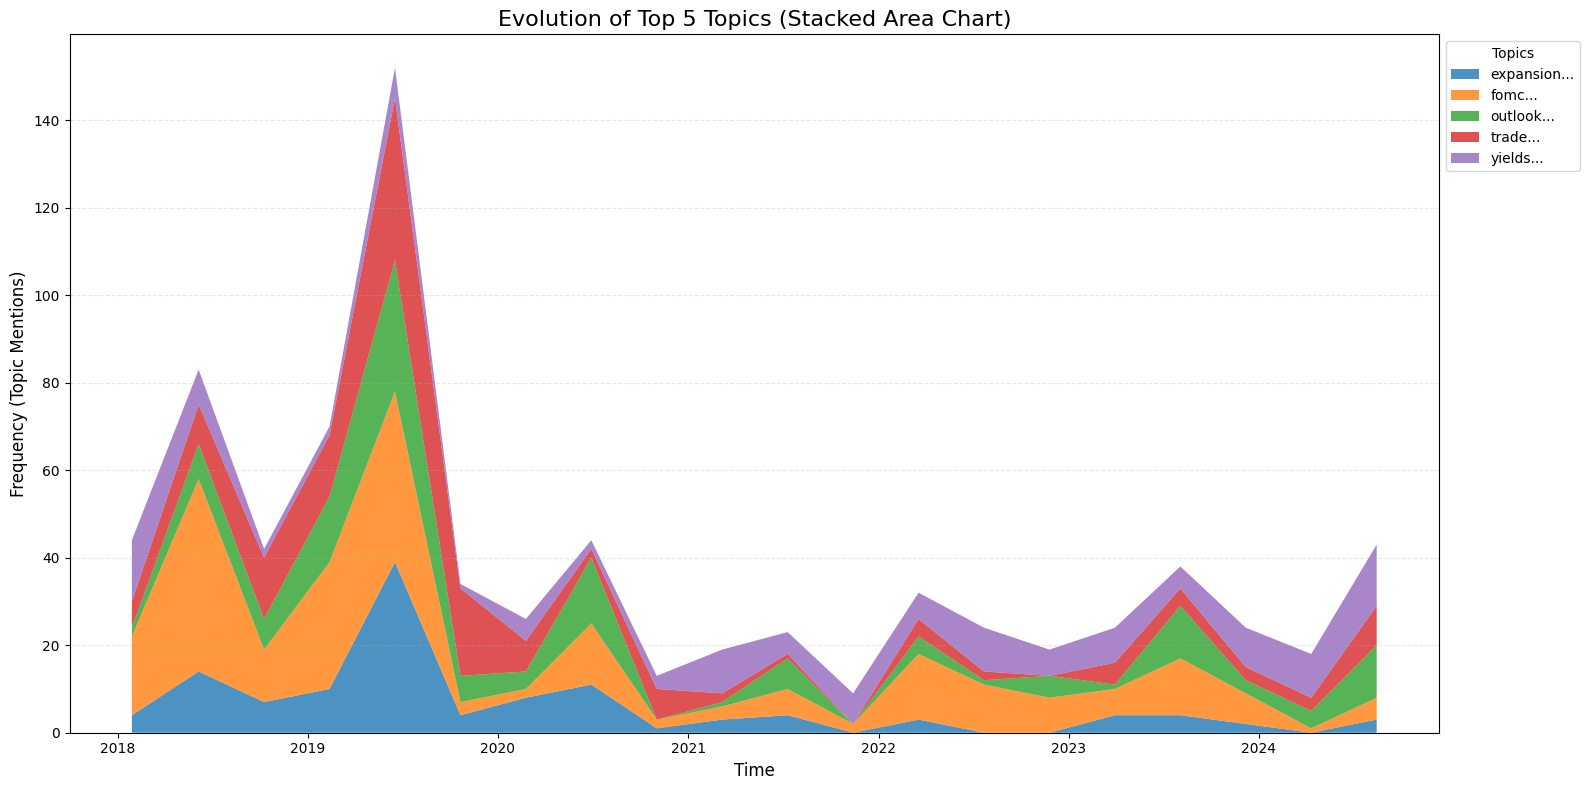

In [6]:
# ... existing code ...
# ==========================================
# 5. 动态主题分析 (Dynamic Topic Modeling - DTM)
# ==========================================
# 这是 Grade A 的核心得分点：展示主题随时间的演变
print("Calculating Topics over Time...")

topics_over_time = topic_model.topics_over_time(docs, timestamps, nr_bins=20)

# 可视化特定主题的演变 (默认折线图)
fig_time = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)
fig_time.write_html("../reports/topics_over_time_line.html")
# fig_time.show()

# ==========================================
# [NEW] 5.1 高级可视化：堆叠面积图 (Stacked Area Chart)
# ==========================================
# 这种图能展示“累加”效果，你可以看到总声量以及各主题的占比

import matplotlib.pyplot as plt
import seaborn as sns

def plot_stacked_topics(topic_model, topics_over_time, top_n=5):
    # 1. 获取 Top N 主题的 ID (排除 -1 噪音)
    top_topics_info = topic_model.get_topic_info()
    # 排除 Topic -1
    top_topics_indices = top_topics_info[top_topics_info['Topic'] != -1].head(top_n)['Topic'].tolist()
    
    # 2. 筛选数据
    df_stack = topics_over_time[topics_over_time['Topic'].isin(top_topics_indices)].copy()
    
    # 3. 获取每个主题的名字 (Name) 而不是 ID，为了图例好看
    # 创建一个 ID 到 Name 的映射字典
    topic_names = {topic: topic_model.get_topic(topic)[0][0] + "..." for topic in top_topics_indices} 
    # 或者直接用 Custom Name 如果你有设置
    # topic_names = {topic: topic_model.topic_names[topic] for topic in top_topics_indices}
    
    df_stack['Topic_Name'] = df_stack['Topic'].map(topic_names)
    
    # 4. 数据透视 (Pivot)
    # 变成: Index=Timestamp, Columns=Topic_Name, Values=Frequency
    df_pivot = df_stack.pivot(index='Timestamp', columns='Topic_Name', values='Frequency').fillna(0)
    
    # 5. 绘图
    plt.figure(figsize=(16, 8))
    
    # 使用 stackplot
    plt.stackplot(df_pivot.index, df_pivot.T, labels=df_pivot.columns, alpha=0.8)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Topics")
    plt.title(f'Evolution of Top {top_n} Topics (Stacked Area Chart)', fontsize=16)
    plt.ylabel('Frequency (Topic Mentions)', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 运行绘图函数
print("Generating Stacked Area Chart...")
plot_stacked_topics(topic_model, topics_over_time, top_n=5)

# ==========================================
# 6. 保存结果
# ==========================================
# ... existing code ...

In [7]:
topics_over_time = topic_model.topics_over_time(docs, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

20it [00:01, 13.00it/s]


## 5. Source Comparison (Scripted vs Unscripted)
Are some topics unique to Q&A?

In [8]:
classes = df['source'].to_list()
topics_per_class = topic_model.topics_per_class(docs, classes=classes)
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10)

3it [00:00,  9.31it/s]
